In [1]:
#------------------------
# Google Colab上でのみ実行
#------------------------
import time
!git clone https://github.com/konnitiha3/MOD2NN.git

import sys
sys.path.append('/content/MOD2NN')

from google.colab import drive
drive.mount('/content/drive')

Cloning into 'MOD2NN'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 204 (delta 111), reused 165 (delta 81), pack-reused 0
Receiving objects: 100% (204/204), 2.60 MiB | 11.13 MiB/s, done.
Resolving deltas: 100% (111/111), done.
Mounted at /content/drive


In [10]:
import time
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
import pandas as pd
from cxlayers import InputToCx, CxMO, AngularSpectrum, CxD2NNIntensity, D2NNMNISTDetector, ImageResizing, ImageBinarization, D2NNMNISTFilter, CxD2NNFaradayRotation, Polarizer

print("TensorFlow:", tf.__version__)
print("Python:", sys.version)
print("OpenCV:", cv2.__version__)

plt.rcParams['font.size'] = 18

TensorFlow: 2.8.0
Python: 3.8.11 (default, Aug 16 2021, 12:04:33) 
[Clang 12.0.0 ]
OpenCV: 4.5.2


shape : ((rcp or lcp), (x_real, x_image, y_real, y_image), width, height)
右ねじが進む方向で正

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

In [3]:
def loss(y_hat, y):
    return tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_hat, logits=y)


def loss_MSE(y_hat, y):
    return tf.reduce_sum((y_hat - y) ** 2)

In [3]:
#@title デフォルトのタイトル テキスト
wavelength = 531.0e-9 #@param {type:"number"}
d = 2.0e-6 #@param {type:"number"}

k = 2 * np.pi / wavelength

### 全結合条件

In [5]:
theta = np.arcsin(wavelength/(2*d))
z = np.sqrt((100*d)**2 + (100*d)**2)/np.tan(theta)
z

0.0021117847698211094

In [6]:
shape = (100, 100)

inputs = tf.keras.Input((28, 28))
x = ImageResize(shape)(inputs)
x = InputToCx(shape)(x)
x = CxMO(shape, limitation='tanh', limitation_num=2.1*np.pi/180)(x)
x = FreeSpacePropagation(shape, k, 0.5e-3, normalization='max', input_pitch=d, output_pitch=d)(x)
x = CxMO(shape, limitation='tanh', limitation_num=2.1*np.pi/180)(x)
x = FreeSpacePropagation(shape, k, 2.0e-3, normalization='max', input_pitch=d, output_pitch=d)(x)
x = CxD2NNFaradayRotation(shape, normalization='minmax')(x)
x = D2NNMNISTDetector(10, activation='softmax')(x)
model = tf.keras.Model(inputs, x)
model.summary()
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",  # category: sparse_categorical_crossentropy
              metrics=['accuracy'])

epochs = 10
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    min_delta=0.05,
    patience=2,
)

result = model.fit(x_train,
                   y_train,
                   batch_size=64,
                   epochs=epochs
                   #callbacks=[early_stopping]
                   )

path = "trained_model/20220319_1"
model.save(path)

df = pd.DataFrame(result.history)
df.to_csv(path + "/history.csv")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 image_resize_1 (ImageResize  (None, 100, 100)         0         
 )                                                               
                                                                 
 input_to_cx_1 (InputToCx)   (None, 2, 4, 100, 100)    0         
                                                                 
 cx_mo_1 (CxMO)              (None, 2, 4, 100, 100)    10000     
                                                                 
 free_space_propagation (Fre  (None, 2, 4, 100, 100)   0         
 eSpacePropagation)                                              
                                                                 
 cx_mo_2 (CxMO)              (None, 2, 4, 100, 100)    10000 

2022-03-22 08:47:36.075843: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-22 08:47:37.456285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 807s 858ms/step - loss: 2.0958 - accuracy: 0.3494
Epoch 2/10
938/938 [==============================] - 801s 854ms/step - loss: 1.9448 - accuracy: 0.4063
Epoch 3/10
938/938 [==============================] - 796s 848ms/step - loss: 1.8674 - accuracy: 0.4330
Epoch 4/10
938/938 [==============================] - 800s 853ms/step - loss: 1.8070 - accuracy: 0.4512
Epoch 5/10
938/938 [==============================] - 798s 850ms/step - loss: 1.7587 - accuracy: 0.4640
Epoch 6/10
938/938 [==============================] - 798s 850ms/step - loss: 1.7189 - accuracy: 0.4725
Epoch 7/10
938/938 [==============================] - 798s 851ms/step - loss: 1.6875 - accuracy: 0.4817
Epoch 8/10
938/938 [==============================] - 798s 850ms/step - loss: 1.6611 - accuracy: 0.4887
Epoch 9/10
938/938 [==============================] - 800s 853ms/step - loss: 1.6356 - accuracy: 0.4941
Epoch 10/10
938/938 [==============================] - 795s 848ms/step - lo

2022-03-22 11:00:47.537511: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: trained_model/20220319_1/assets


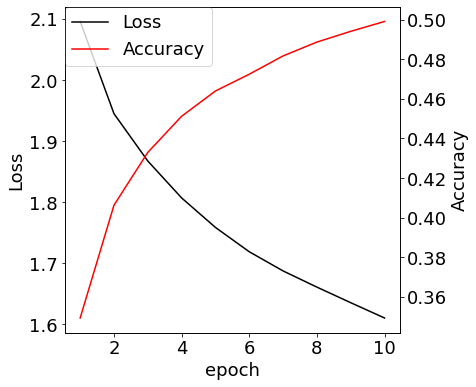

In [7]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.plot(range(1, epochs + 1), result.history['loss'], color='black', label='Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('epoch')
ax2.plot(range(1, epochs + 1), result.history['accuracy'], color='red', label='Accuracy')
ax2.set_ylabel('Accuracy')
# label1と2には、凡例用に各labelのリスト情報が入る
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
# 凡例をまとめて出力する
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)

In [6]:
model.evaluate(x_test, y_test)

2022-03-16 12:02:32.917280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 57s 180ms/step - loss: 0.5076 - accuracy: 0.8537


[0.5075562000274658, 0.8537000417709351]

In [8]:
layer_name = model.layers[-2].name
hidden_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
filter_y = D2NNMNISTFilter((100, 100))(model.get_layer(layer_name).output)
filter_model = tf.keras.Model(inputs=model.input, outputs=filter_y)

2022-03-22 11:02:16.195437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-22 11:02:17.373916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-22 11:02:18.159984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


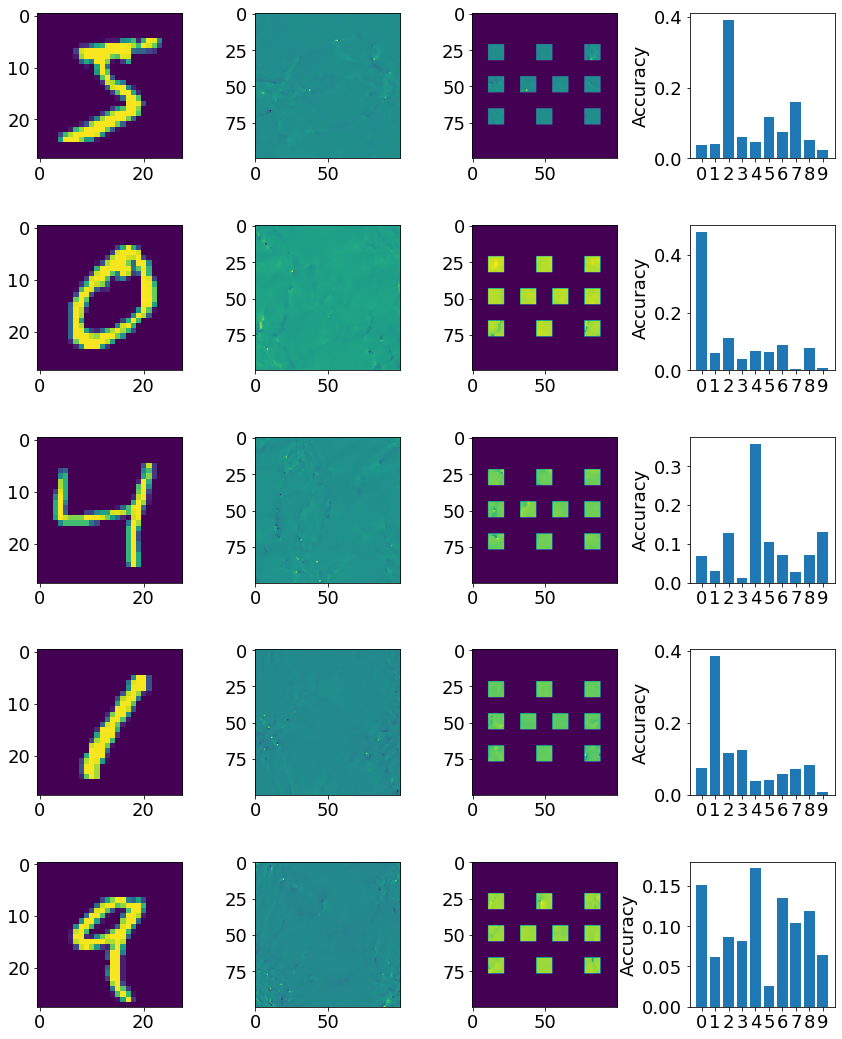

In [9]:
num = 5
images = x_train[0:num, :, :]

preds = model.predict(images)
pred_images = hidden_layer_model.predict(images)
filtered_images = filter_model.predict(images)
fig, axes = plt.subplots(num, 4, figsize=(12, 3 * num))
for i in range(num):
    axes[i, 0].imshow(images[i, :, :])
    axes[i, 1].imshow(pred_images[i, :, :])
    axes[i, 2].imshow(filtered_images[i,:,:])
    axes[i, 3].bar(np.arange(0, 10, 1), preds[i, :], align='center')
    axes[i, 3].set_xticks(np.arange(0, 10, 1))
    axes[i, 3].set_ylabel('Accuracy')
    axes[i, 3].set_aspect(1./axes[i, 3].get_data_ratio())
fig.tight_layout()

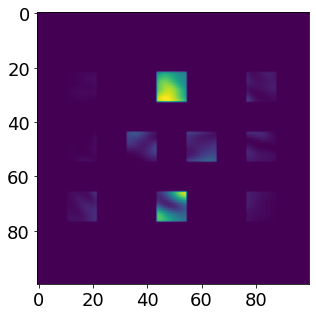

In [16]:
plt.figure(figsize=(5,5))
plt.imshow(filtered_images[0,:,:])

In [ ]:
layer_outputs = [layer.output for layer in model.layers[1:]]
layer_outputs

In [ ]:
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)
activation_model.summary()

In [ ]:
num = 5
images = x_train[0:num, :, :]
activations = activation_model.predict(images)
len(activations)

In [ ]:
fig, axes = plt.subplots(num, len(activations) - 2, figsize=(2 * len(activations) - 1, 2 * num))
for i in range(len(activations) - 2):
    layer_activation = activations[i]
    for j in range(num):
        intensity = tf.sqrt(layer_activation[j, 0, :, :] ** 2 + layer_activation[j, 1, :, :] ** 2)
        axes[j, i].imshow(intensity)

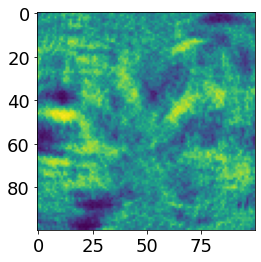

In [13]:
plt.imshow(tf.tanh(model.layers[5].get_weights()[0]))

AttributeError: 'Resizing' object has no attribute 'adapt'

In [12]:
processing = tf.keras.layers.experimenta.procesing

inputs = tf.keras.Input((28, 28))

x = ImageResize((100, 100))(inputs)
x = InputToCx((100, 100))(x)
x = CxMO((100, 100))(x)
x = FreeSpacePropagation((100, 100), 2*np.pi/633e-9, 0.5e-3)(x)
x = CxD2NNIntensity((100, 100))(x)
x = D2NNMNISTDetector(10)(x)

model = tf.keras.Model(inputs, x)
model.summary()

inputtocx: 0.011839791999818772
propagation: 0.030384291000018493
intensity: 0.010773833000030208
detector: 0.005371208000042316
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 image_resize_2 (ImageResize  (None, 100, 100)         0         
 )                                                               
                                                                 
 input_to_cx_2 (InputToCx)   (None, 2, 4, 100, 100)    0         
                                                                 
 cx_mo (CxMO)                (None, 2, 4, 100, 100)    10000     
                                                                 
 free_space_propagation_2 (F  (None, 2, 4, 100, 100)   0         
 reeSpacePropagation)                                         

In [14]:
start = time.perf_counter()
pred = model.predict(x_train[0:100,:,:])
print(time.perf_counter()-start)

0.8026921250000214
